In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import keras

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
!pip install keras-lookahead

In [2]:
keras.__version__

'2.4.0'

In [2]:
cols = ['EventDescription', 'Address', 'IncidentCause', 'ActionTaken', 'FailedAssets', 'Locality','IncidentConsequence', 'CauseTechnical', 'CauseTechnical', 'Category']

In [21]:
df2 = pd.read_csv('processed_dataset_IG.csv', usecols=cols)
df2.head()

,ActionTaken,Address,CauseTechnical,EventDescription,FailedAssets,IncidentCause,IncidentConsequence,Locality,Category
0,Crew isolated supply and undertook repairs,"PARA PARK, 1490 HENDY MAIN ROAD, PARAPARAP VIC...",Earth fault,A nearby customer reported sparking of electri...,Conductor (ABC),HVABC cable faulted midspan,Grassfire,Paraparap,OH Cable
1,Crew undertook repairs,"1154-1198 CHRISTIES ROAD, RAVENHALL VIC 3023",Leakage,A contractor reported that he had contacted an...,No failed asset,Contractor contacted earthing conductor,No Go Zone (contact),Ravenhall,Dug up
2,Crew isolated supply and undertook repairs,"326 DUNBARS ROAD, PETERBOROUGH VIC 3270",Corrosion,A field crew attending an outage found that a ...,Conductor (bare),Conductor broke due to rust,Serious risk to public safety (e.g. live condu...,Peterborough,Connection
3,Crew undertook repairs,"41-49 BANK STREET, SOUTH MELBOURNE VIC 3205",Leakage,Interfere and vandalism in substation. Unknown...,Indoor,Vandalism,Loss of supply;Damage to network assets,South Melbourne,Other
4,Crew isolated supply and undertook repairs,"199 WILSONS ROAD, WHITTINGTON VIC 3219",Leakage,A nearby customer reported that a high load ha...,Service conductor,Unknown high load contacted LV service cable,No Go Zone (contact);Damage to network assets,Whittington,Vehicle


In [23]:
#concatenate only the text features
df2['description'] = df2['EventDescription'] + ' ' + df2['Address'] + ' '+ df2['IncidentCause'] + ' ' + df2['ActionTaken'] +\
    ' '+ df2['FailedAssets'] +' ' + df2['Locality']  + ' ' + df2['IncidentConsequence'] + ' ' + \
    df2['CauseTechnical'] + ' ' + df2['CauseTechnical']

In [24]:
df2['description']

0       A nearby customer reported sparking of electri...
1       A contractor reported that he had contacted an...
2       A field crew attending an outage found that a ...
3       Interfere and vandalism in substation. Unknown...
4       A nearby customer reported that a high load ha...
                              ...                        
6438    A report came in to UE of a FMB sparking at 31...
6439    Report received from a resident to advise that...
6440    Report received of pole fire at incident locat...
6441    A customer called to report a tractor had hit ...
6442    concrete electrical cover outside of front of ...
Name: description, Length: 6443, dtype: object

In [26]:
import scipy 
from scipy import stats

le = LabelEncoder()
df2['Category'] = le.fit_transform(df2.Category.astype(str))
df2['Category'].unique()

array([ 9,  5,  3, 10, 14,  6, 12, 11,  4,  2,  1,  0,  8, 13,  7])

In [27]:
#Preprocessing by general cleaning by removing reg expressions, numbers and alphanumericals
import nltk 
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df2['description'] = df2['description'].apply(clean_text)

df2['description']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       nearby customer reported sparking electrical l...
1       contractor reported contacted earthing cable e...
2       field crew attending outage found 22kv conduct...
3       interfere vandalism substation unknown third p...
4       nearby customer reported high load pulled wire...
                              ...                        
6438    report came ue fmb sparking 310 st kilda st br...
6439    report received resident advise crane made con...
6440    report received pole fire incident locationon ...
6441    customer called report tractor hit wire brough...
6442    concrete electrical cover outside front house ...
Name: description, Length: 6443, dtype: object

In [28]:
max_words = 1000*5 #limiting the max vocabulary to 5000
max_len = 100*1 #Limiting the max word count in a row/sentence to 100
tok = Tokenizer(num_words=max_words,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tok.fit_on_texts(df2['description']) #tok learns the vocabulary of df2['description']

sequences = tok.texts_to_sequences(df2['description']) #encoding the tokens to integers
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #augment the length of words in rows by adding zeros
print(sequences_matrix.shape)


(6443, 100)


In [29]:
#sequences_matrix is converted into a dataframe 
df = pd.DataFrame(sequences_matrix)
#with the use of padsequencing we can see the length throughout the rows are equal, by adding zeros in place of missing words

In [30]:
Y = df2['Category']
Y

0        9
1        5
2        3
3       10
4       14
        ..
6438     3
6439    14
6440    11
6441    14
6442     0
Name: Category, Length: 6443, dtype: int32

In [31]:
x_train,x_test,y_train,y_test = train_test_split(df,Y,test_size=0.15, stratify=Y)

In [32]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5476, 100) (5476,) (967, 100) (967,)


In [35]:
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [36]:
units_mul = 100*2
unique_categories = np.unique(Y)
print(unique_categories)
labels_count = len(unique_categories)
dropout = 0.4

def RNN3():
  model = tf.keras.Sequential()
  

  model.add(Embedding(max_words, units_mul, input_length=x_train.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(dropout))
  model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Bidirectional(LSTM(units_mul, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dense(labels_count, activation='softmax'))
  return model

RNN3().summary()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 200)           120200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 15)                6015      
Total params: 1,767,815
Trainable params: 1,767,815
Non-trainable params: 0

In [37]:
from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler
optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(optimiser, sync_period=5, slow_step=0.5, name = 'Lookahead')

#The step decay learning rate
#Step Decay A typical way is to to drop the learning rate by half every 10 epochs 
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    return float(alpha)


# train model
model = RNN3()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  history = model.fit(x_train,y_train, batch_size=128,
                    epochs=10, 
                    validation_split=0.2,
                    callbacks=[LearningRateScheduler(step_decay)])


Epoch 1/10
105/105 [==============================] - 141s 1s/step - loss: 1.6392 - accuracy: 0.4465 - val_loss: 4.7231 - val_accuracy: 0.0983
Epoch 2/10
105/105 [==============================] - 130s 1s/step - loss: 1.2345 - accuracy: 0.5789 - val_loss: 5.4329 - val_accuracy: 0.1117
Epoch 3/10
105/105 [==============================] - 130s 1s/step - loss: 1.1234 - accuracy: 0.6179 - val_loss: 5.5483 - val_accuracy: 0.1036
Epoch 4/10
105/105 [==============================] - 139s 1s/step - loss: 1.0672 - accuracy: 0.6345 - val_loss: 5.9010 - val_accuracy: 0.0729
Epoch 5/10
105/105 [==============================] - 154s 1s/step - loss: 0.9332 - accuracy: 0.6875 - val_loss: 6.5104 - val_accuracy: 0.1022
Epoch 6/10
105/105 [==============================] - 142s 1s/step - loss: 0.8494 - accuracy: 0.7111 - val_loss: 6.8777 - val_accuracy: 0.0851
Epoch 7/10
105/105 [==============================] - 140s 1s/step - loss: 0.8028 - accuracy: 0.7289 - val_loss: 7.0625 - val_accuracy: 0.0899

In [38]:
accr = model.evaluate(x_test,y_test)
print(accr[1])

31/31 [==============================] - 2s 72ms/step - loss: 0.8775 - accuracy: 0.7632
0.7631850838661194


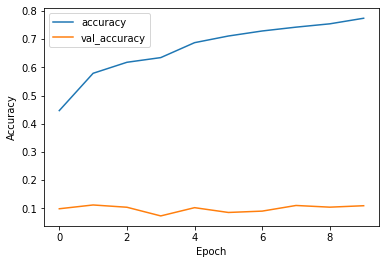

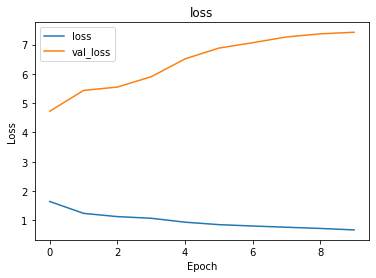

In [39]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

